In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from torchvision import transforms
from torch.utils.data import random_split, DataLoader
import torchvision.models as models

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import re
import matplotlib.pyplot as plt

from classifiers import *

### Weird loader for model 2 - axion class has to be processed differently


In [2]:
class NpyClassDataset(torch.utils.data.Dataset):
    def __init__(self, root_folder, transform=None, noise_mean=0.0, noise_std=0.0):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.noise_mean = noise_mean
        self.noise_std = noise_std

        # Map class names to integer labels (sorted for consistency)
        self.class_to_label = {'axion': 0, 'cdm': 1, 'no_sub': 2}

        for class_name, label in self.class_to_label.items():
            class_folder = os.path.join(root_folder, class_name)
            for fname in os.listdir(class_folder):
                if fname.endswith('.npy'):
                    self.image_paths.append(os.path.join(class_folder, fname))
                    self.labels.append(label)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image and select correct component
        img = np.load(path, allow_pickle=True)
        img = img[0] if label == 0 else img
        img = img.astype(np.float32)

        # Normalize to [0, 1] using min-max scaling
        img_min = np.min(img)
        img_max = np.max(img)
        if img_max - img_min > 1e-8:
            img = (img - img_min) / (img_max - img_min)
        else:
            img = np.zeros_like(img)
            print('EMPTY IMAGE!!')

        # Add Gaussian noise
        if self.noise_std > 0:
            noise = np.random.normal(loc=self.noise_mean, scale=self.noise_std, size=img.shape).astype(np.float32)
            img += noise
            img = np.clip(img, 0.0, 1.0)  # Ensure pixel values remain valid

        # Add channel dim if needed
        if img.ndim == 2:
            img = img[None, :, :]

        img = torch.tensor(img, dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, label


### Data loading and augmentation for the training set

In [4]:
# transform_train = transforms.Compose([
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), 
#     transforms.RandomRotation(90)            
# ])

### Loading the dataset with additional Gaussian noise

In [6]:
# Load the full dataset (just training folder)
full_ds = NpyClassDataset('./Model_II', noise_mean=0.01, noise_std=0.005)

# Set split size (e.g., 10% for validation)
val_size = int(0.10 * len(full_ds))
train_size = len(full_ds) - val_size

# For reproducibility
generator = torch.Generator().manual_seed(42)

# Split into train/val
train_ds, val_ds = random_split(full_ds, [train_size, val_size], generator=generator)

# Loaders
train_loader = DataLoader(train_ds, batch_size=512, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=512, shuffle=False)

### Initializing the model

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18GrayscaleFD(num_classes=3, dropout_p=0.1, bottleneck_dim=512).to(device)

In [8]:
model.load_state_dict(torch.load('noisy_classifier_512.pt'), strict = False) 

<All keys matched successfully>

### Training the model

In [ ]:
num_epochs = 20
log_file = "logs/training_log.txt"
os.makedirs(os.path.dirname(log_file), exist_ok=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Optional: enable anomaly detection for debugging
# torch.autograd.set_detect_anomaly(True)

# --- Training Loop ---
with open(log_file, 'w') as f:
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        f.write(f"Epoch {epoch+1}/{num_epochs}\n")

        # --- Training ---
        model.train()
        running_train_loss = 0.0
        total_train = 0
        correct_train = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

            # if batch_idx % 100 == 0:
            #     print(f"[Train | Batch {batch_idx}] Loss: {loss.item():.4f}")

        avg_train_loss = running_train_loss / total_train
        train_accuracy = correct_train / total_train

        # --- Validation ---
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(val_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)
                preds = outputs.argmax(dim=1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

                # if batch_idx % 40 == 0:
                #     print(f"[Val | Batch {batch_idx}] Loss: {loss.item():.4f}")

        avg_val_loss = running_val_loss / total_val
        val_accuracy = correct_val / total_val

        # --- Logging ---
        log_line = (f"Epoch {epoch+1:03d}: "
                    f"Train Loss = {avg_train_loss:.4f}, Acc = {train_accuracy:.4f} | "
                    f"Val Loss = {avg_val_loss:.4f}, Acc = {val_accuracy:.4f}")
        print(log_line)
        f.write(log_line + '\n')

        # --- Save checkpoint ---
        checkpoint_path = f"classifier_model_epoch_{epoch+1:03d}.pt"
        # torch.save(model.state_dict(), checkpoint_path)



Epoch 1/20
Epoch 001: Train Loss = 0.0489, Acc = 0.9832 | Val Loss = 0.1128, Acc = 0.9660

Epoch 2/20
Epoch 002: Train Loss = 0.0496, Acc = 0.9828 | Val Loss = 0.0943, Acc = 0.9710

Epoch 3/20
Epoch 003: Train Loss = 0.0500, Acc = 0.9827 | Val Loss = 0.0940, Acc = 0.9717

Epoch 4/20
Epoch 004: Train Loss = 0.0481, Acc = 0.9829 | Val Loss = 0.0950, Acc = 0.9721

Epoch 5/20
Epoch 005: Train Loss = 0.0450, Acc = 0.9845 | Val Loss = 0.0804, Acc = 0.9755

Epoch 6/20
Epoch 006: Train Loss = 0.0473, Acc = 0.9836 | Val Loss = 0.0988, Acc = 0.9688

Epoch 7/20
Epoch 007: Train Loss = 0.0460, Acc = 0.9840 | Val Loss = 0.1033, Acc = 0.9676

Epoch 8/20
Epoch 008: Train Loss = 0.0448, Acc = 0.9841 | Val Loss = 0.0842, Acc = 0.9737

Epoch 9/20
Epoch 009: Train Loss = 0.0422, Acc = 0.9855 | Val Loss = 0.1140, Acc = 0.9645

Epoch 10/20
Epoch 010: Train Loss = 0.0433, Acc = 0.9850 | Val Loss = 0.0879, Acc = 0.9726

Epoch 11/20
Epoch 011: Train Loss = 0.0413, Acc = 0.9857 | Val Loss = 0.0936, Acc = 0.97

In [11]:
torch.save(model.state_dict(), 'more_noisy_classifier_512.pt')

<ipython-input-26-688e3e3c5889>:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


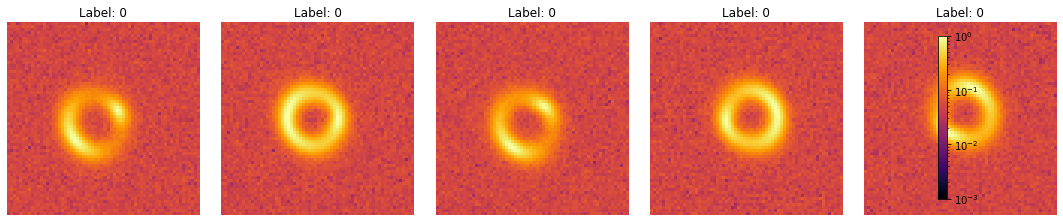

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


# Load your dataset (adjust path and noise if needed)
dataset = full_ds

# Select how many samples to show
num_samples = 5
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i in range(num_samples):
    img, label = dataset[i]
    img_np = img.squeeze().numpy()

    # Avoid issues with log scale by adding epsilon and clipping
    img_safe = img_np.clip(min=1e-4)  # Ensure no zeros or negatives

    ax = axes[i]
    im = ax.imshow(img_safe, cmap='inferno', norm=LogNorm(vmin=1e-3, vmax=1.0))
    ax.axis('off')
    ax.set_title(f"Label: {label}")

# Add colorbar
fig.colorbar(im, ax=axes, fraction=0.025, pad=0.04)
plt.tight_layout()
plt.show()


### Loading previously trained model

In [ ]:
# model.load_state_dict(torch.load('test_1.pt'))

### Evaluating the model on the validation set and obtaining ROC and AUC

In [ ]:
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)  # raw logits
        probs = torch.softmax(outputs, dim=1)  # probabilities
        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_probs = np.vstack(all_probs)
all_labels = np.concatenate(all_labels)

In [ ]:
n_classes = 3
y_true = label_binarize(all_labels, classes=[0, 1, 2])  # shape: (N, 3)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

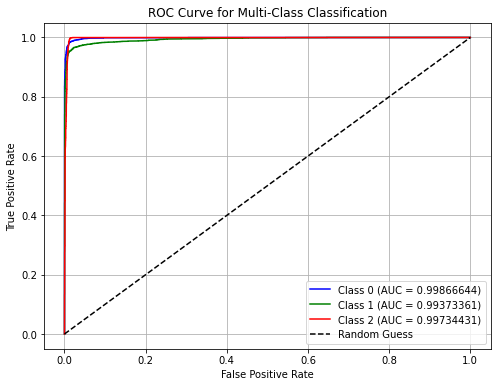

In [ ]:
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f"Class {i} (AUC = {roc_auc[i]:.8f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend()
plt.grid()
plt.show()
